#Reading Data

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 21 08:09:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
######################################
#Import images from Google Drive to Colab
######################################
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import sys
os.chdir('/content/gdrive/MyDrive/ThesisData')
sys.path.append("/content/gdrive/MyDrive/ThesisData")
!pwd

/content/gdrive/MyDrive/ThesisData


#Import Library

In [4]:
#Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image Preprocessing

In [5]:
# Defime image size
imgWidth = 224
imgHeight = 224

In [6]:
# image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = "../ThesisData"

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(imgWidth, imgHeight),
                                                 batch_size=64,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir+'/val',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = test_datagen.flow_from_directory(base_dir+'/test',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle=False)


Found 10024 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.


In [7]:
train_num = training_set.samples
valid_num = valid_set.samples

In [8]:
num_classes = 10
input_shape = (imgHeight, imgWidth , 3)

#VGG16 with CheckPoint

##Train Model

In [9]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

In [10]:
InceptionV3Model = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 2s 0us/step


In [11]:
for layer in InceptionV3Model.layers:
    layer.trainable = False

In [12]:
x = Flatten()(InceptionV3Model.output)

prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=InceptionV3Model.input, outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["accuracy"]
)

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG16.hf5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

In [18]:
import pickle
history = model.fit(
                  training_set,
                  validation_data=valid_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(valid_set)
                )

#saving model
model.save("InceptionV3_Model.hdf5")


# Save the training history to a file using pickle
with open('InceptionV3CheckPt_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.8475 - accuracy: 0.8302
Epoch 1: val_loss improved from inf to 0.73505, saving model to /temp/1_VGG16.hf5
157/157 [==============================] - 488s 3s/step - loss: 0.8475 - accuracy: 0.8302 - val_loss: 0.7351 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.8617
Epoch 2: val_loss improved from 0.73505 to 0.64057, saving model to /temp/2_VGG16.hf5
157/157 [==============================] - 231s 1s/step - loss: 0.7824 - accuracy: 0.8617 - val_loss: 0.6406 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.8792 - accuracy: 0.8689
Epoch 3: val_loss improved from 0.64057 to 0.50901, saving model to /temp/3_VGG16.hf5
157/157 [==============================] - 230s 1s/step - loss: 0.8792 - accuracy: 0.8689 - val_loss: 0.5090 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 4/20
157/157 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Print Metrics

In [19]:
from keras.models import load_model

#Load model from a saved model file
model = load_model('/content/gdrive/MyDrive/ThesisData/InceptionV3_Model.hdf5')

In [20]:
from time import time
start = time()
evl = model.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

20/20 [==============================] - 264s 14s/step - loss: 1.0074 - accuracy: 0.9513
Test Accuracy = 95.13 %
Test Loss = 100.74 %
Test Time = 277.50 s


In [21]:
from sklearn.metrics import classification_report
# Make predictions on the test set
predicted_labels = model.predict(test_set)
# Convert predicted probabilities to class labels (if necessary)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Calculate classification report
report = classification_report(test_set.labels, predicted_classes)
print(report)

20/20 [==============================] - 15s 554ms/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       132
           1       0.94      0.96      0.95       124
           2       0.92      0.96      0.94       124
           3       0.98      0.98      0.98       125
           4       0.98      0.97      0.97       124
           5       0.96      0.99      0.98       125
           6       0.97      0.96      0.96       124
           7       0.95      0.92      0.94       126
           8       0.92      0.98      0.95       124
           9       0.96      0.85      0.90       125

    accuracy                           0.95      1253
   macro avg       0.95      0.95      0.95      1253
weighted avg       0.95      0.95      0.95      1253



In [22]:
# Access the mean accuracy and loss of training from the history object
average_accuracy = np.average(history.history['accuracy'])
average_loss = np.average(history.history['loss'])

print("Training - Average Accuracy:", average_accuracy)
print("Training - Average Loss:", average_loss)

# Access the average accuracy and loss of validation from the history object
average_accuracyVal = np.average(history.history['val_accuracy'])
average_lossVal = np.average(history.history['val_loss'])

print("Validation - Average Accuracy:", average_accuracyVal)
print("Validation - Average Loss:", average_lossVal)

Training - Average Accuracy: 0.9134178042411805
Training - Average Loss: 0.7310846120119094
Validation - Average Accuracy: 0.9399840384721756
Validation - Average Loss: 0.8105578273534775


##Visualising Training Progress

Training accuracy: [0.8302075266838074, 0.8617318272590637, 0.8689146041870117, 0.8932561874389648, 0.9141061305999756, 0.8893654942512512, 0.9136073589324951, 0.9146049618721008, 0.9173982739448547, 0.9314644932746887, 0.9217877388000488, 0.9264764785766602, 0.9225857853889465, 0.9291700124740601, 0.9353551268577576, 0.9328611493110657, 0.9452314376831055, 0.9419393539428711, 0.9420391321182251, 0.936253011226654]
Validation accuracy: [0.8715083599090576, 0.9050279259681702, 0.9401436448097229, 0.943336009979248, 0.9122107028961182, 0.9457302689552307, 0.9465283155441284, 0.9417397975921631, 0.9425379037857056, 0.9545091986656189, 0.9521149396896362, 0.9465283155441284, 0.9569034576416016, 0.9521149396896362, 0.9529129862785339, 0.9497206807136536, 0.9529129862785339, 0.9473264217376709, 0.9345570802688599, 0.9513168334960938]
Training loss: [0.8474801778793335, 0.782420814037323, 0.8792429566383362, 0.7268519401550293, 0.6217176914215088, 0.8939792513847351, 0.6880833506584167, 0.741

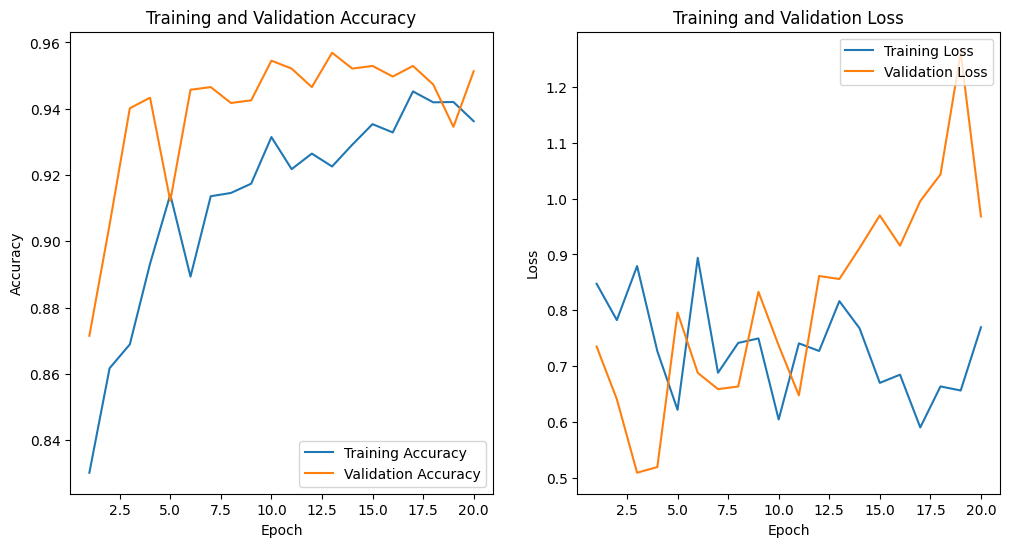

In [23]:
################################
# Visualize the loss and accuracy
###############################
#accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy:", acc)
print("Validation accuracy:", val_acc)

#loss accuracy and validation loss accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss:", loss)
print("Validation loss:", val_loss)

epochs = range(1, len(loss) + 1)

#Plot Training Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('InceptionV3CheckPt_History.png')
plt.show()

In [24]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 9 9 9]
20/20 [==============================] - 8s 396ms/step
Predicted :  [0 2 4 ... 9 9 9]


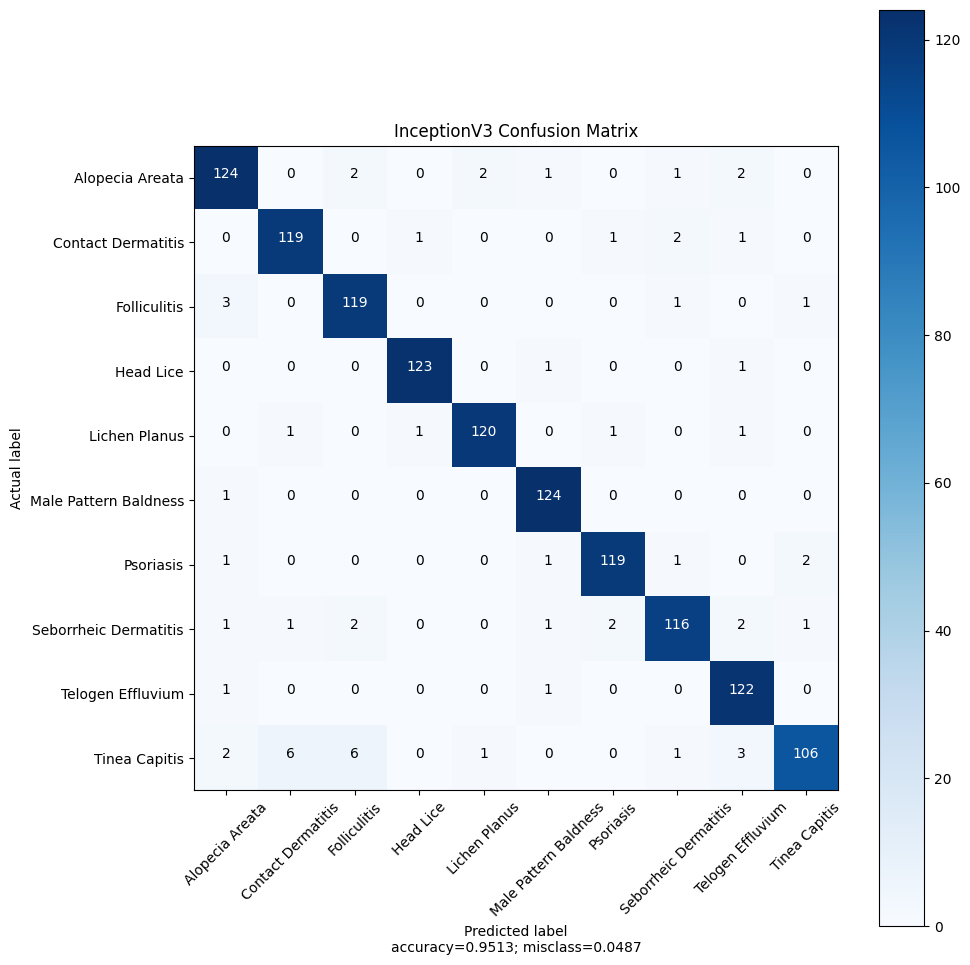

In [25]:
from sklearn.metrics import confusion_matrix

classes = ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "InceptionV3 Confusion Matrix")